# Analysis of material characteristics

#### The code below is used to analyse an hyperelastic material called pebax, which are used in the manufacturing of angioplasty balloons.

#### First the material behaviour was tested using uniaxial testing at the strain rate of 0.001mm/sec with a 50N load cell. A total of 8 samples were tested and their force-displacement curves were obtained

#### The strain-strain data was obtained from the force displacement curves and were fitted with three different hyperelastic models to find the best fit.

In [122]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


In [123]:
#import data 

df = pd.read_csv(r'C:\Users\hp\Desktop\mean uniaxial data_for python.csv')
a,b = df.shape
FD= np.transpose(df.to_numpy())


In [124]:
#intial values

L = [12.8361, 13.3893, 12.842, 12.9851, 13.2014, 12.962, 13.2393] #length of the sample
mean_L = np.mean(L) 
width = 6   # width of the samples
thickness = 0.05 # thickness of the samples


In [149]:
# calculating the mean Force - disp from the 7 samples

min_ax = [0]*7
max_ax = [0]*7
new_ax = [0]*7
new_ay = [0]*7
j=0

for i in range(0, len(FD)-1, 2):
    min_ax[j] = min(FD[i])
    max_ax[j] = max(FD[i])
    
    new_ax[j] = np.linspace(min_ax[j], max_ax[j], 3000)
    new_ay[j] = np.interp(new_ax[j], FD[i], FD[i+1])
    
    j=j+1
    
middisp= [0]*(len(new_ax[1])-1)
midforc= [0]*(len(new_ax[1])-1)

for i in range(0,2999):
    middisp[i] = np.mean([new_ax[0][i], new_ax[1][i], new_ax[2][i], new_ax[3][i], new_ax[4][i], new_ax[5][i], new_ax[6][i]]) 
    midforc[i] = np.mean([new_ay[0][i], new_ay[1][i], new_ay[2][i], new_ay[3][i], new_ay[4][i], new_ay[5][i], new_ay[6][i]]) 



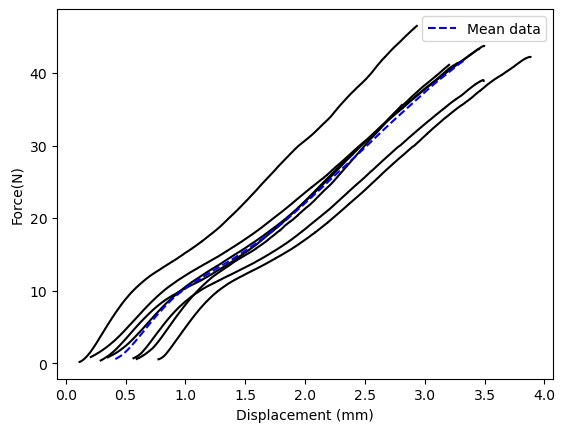

In [155]:
# plot force-Disp curves (Sample and mean)
l=1
for i in range(0,len(FD)-1,2):
    plt.plot(FD[i], FD[i+1],c='black')
    
plt.plot(middisp, midforc, '--', c='blue',label='Mean data')
plt.legend()
plt.ylabel('Force(N)')
plt.xlabel('Displacement (mm)')
plt.show()

In [159]:
# stress strain function

def stressstrain(xx,yy,L):
    x = np.array(xx)
    y = np.array(yy)
    Strain= x/L
    Stress=y/(width*thickness)
    plt.plot(Strain,Stress, 'g--',label='Mean stress-strain')
    plt.legend()
    plt.ylabel('Stress(MPa)')
    plt.xlabel('Strain(mm)')
    return Strain, Stress


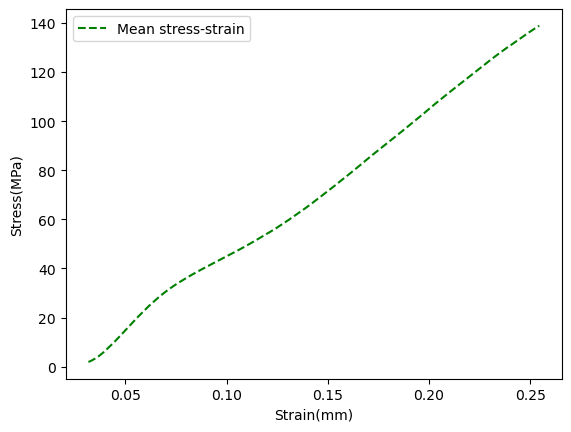

In [160]:
# Compute the mean stress strain curve

Strain1,Stress1 = stressstrain(middisp, midforc, mean_L)

#### For the Uniaxial testing the invariants are calculated as

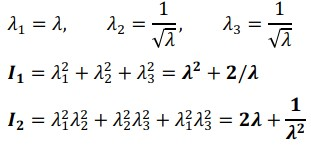

In [161]:
# Finding the stretch(lambd) and the invariants(Inv1 and Inv2)

lambd= np.zeros(len(midforc))
Inv1= np.zeros(len(midforc))
Inv2= np.zeros(len(midforc))

for jj in range(0,len(midforc)):
    lambd[jj] = (mean_L+middisp[jj])/mean_L
    Inv1[jj] = lambd[jj]**2+(2/lambd[jj])
    Inv2[jj] = 1/lambd[jj]**2+(2*lambd[jj])

XX = lambd,Inv1
YY = lambd,Inv1,Inv2

### Yeoh Model

In [162]:
# Yeoh Function

def yeoh(XX,C10,C20,C30):
    lambdd, Inv11 = XX
    ystress = 2*(-1/lambdd**2+lambdd)*(3*C30*(Inv11-3)**2+C10+2*C20*(Inv11-3))
    return ystress

In [165]:
# Calculating Yeoh fitting

parameters,covariance = curve_fit(yeoh,(lambd,Inv1),Stress1)

C1,C2,C3 = parameters
zz = yeoh((lambd,Inv1), C1, C2, C3)

In [166]:
# fitting error
Err= np.zeros(len(Stress1)-1)

for kk in range(0,len(Stress1)-1):
    Err[kk] = (1-zz[kk]/Stress1[kk])**2
    
YeohError = sum(Err)

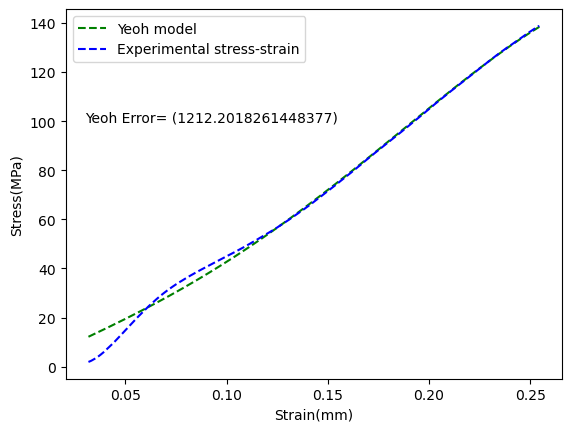

In [182]:
# Experimental vs Yeoh model

plt.plot(Strain1, yeoh(XX, *parameters), 'g--',label='Yeoh model')
plt.plot(Strain1, Stress1, 'b--',label='Experimental stress-strain')
plt.text(0.03,100,'Yeoh Error= (%s)' %YeohError)
plt.legend()
plt.ylabel('Stress(MPa)')
plt.xlabel('Strain(mm)')
plt.show()

### Mooney-Rivlen Model

In [175]:
# Mooney-Rivlen function definition

def mooney(YY,C110,C001):
    lambddd, Inv111, Inv222 = YY
    mstress = 2*(1-1/lambddd**3)*((lambddd*C110)+C001)
    return mstress

In [176]:
# Calculating the mooney-rivlen fitting

parameters1,covariance1 = curve_fit(mooney,(lambd,Inv1,Inv2),Stress1)

C1101,C0001 = parameters1
zzz = mooney((lambd,Inv1,Inv2), C1101,C0001)


In [177]:
# fitting error

Errm= np.zeros(len(Stress1)-1)

for kk in range(0,len(Stress1)-1):
    Errm[kk] = (1-zzz[kk]/Stress1[kk])**2
    
MooneyError = sum(Errm)

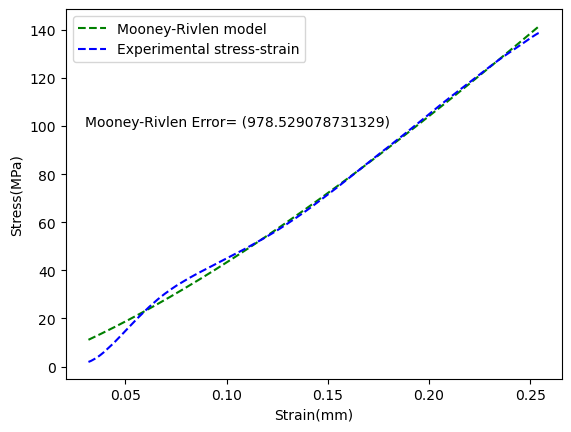

In [181]:
# Experimental vs Mooney-Rivlen model


plt.plot(Strain1, mooney(YY, *parameters1), 'g--',label='Mooney-Rivlen model')
plt.plot(Strain1, Stress1, 'b--',label='Experimental stress-strain')
plt.text(0.03,100,'Mooney-Rivlen Error= (%s)' %MooneyError)
plt.legend()
plt.ylabel('Stress(MPa)')
plt.xlabel('Strain(mm)')
plt.show()

## Polynomial Form model

In [184]:
# polynomial form function definition

def polyn(YY,CC10,CC11,CC20,CC01,CC02):
    lambddd, Inv111, Inv222 = YY
    pstress = 2*(1-1/lambddd**3)*((lambddd*(CC10+CC11*(Inv2-3)+2*CC20*(Inv1-3)))+(CC01+CC11*(Inv1-3)+2*CC02*(Inv2-3)))
    return pstress

In [185]:
# Calculating the polynomial form fitting

parametersp,covariancep = curve_fit(polyn,(lambd,Inv1,Inv2),Stress1)

CC10,CC11,CC20,CC01,CC02 = parametersp
zzzp = polyn((lambd,Inv1,Inv2),CC10,CC11,CC20,CC01,CC02)

In [186]:
# Fitting Error

Errp= np.zeros(len(Stress1)-1)

for kk in range(0,len(Stress1)-1):
    Errp[kk] = (1-zzzp[kk]/Stress1[kk])**2
    
polyError = sum(Errp)

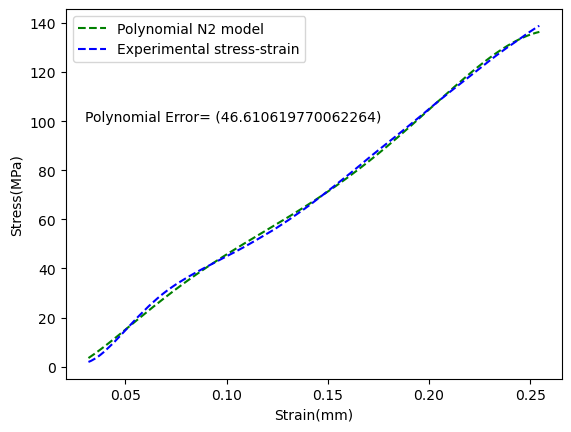

In [187]:
# Experimental vs Polynomial(N=2) model

plt.plot(Strain1, polyn(YY, *parametersp), 'g--',label='Polynomial N2 model')
plt.plot(Strain1, Stress1, 'b--',label='Experimental stress-strain')
plt.text(0.03,100,'Polynomial Error= (%s)' %polyError)
plt.legend()
plt.ylabel('Stress(MPa)')
plt.xlabel('Strain(mm)')
plt.show()
plt.show()

### It is concluded from the above analysis that the polynomial form N2 model has the best fitting with least error = 46.6 compared to the Yeoh and Mooney-Rivlen models
